In [105]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.preprocessing import SplineTransformer
import patsy
from patsy import dmatrix
from matplotlib.lines import Line2D 


In [2]:
hrs_hcap = pd.read_csv('/Users/novak/Columbia-IPHD Dropbox/Shared/HCAP/python file/hrs-hcap.csv')
mex_cog = pd.read_csv('/Users/novak/Columbia-IPHD Dropbox/Shared/HCAP/python file/mex-cog.csv')

In [3]:
# some preparation for the dataset 

## mexcog mmse data was created and named 'mmse_25' in replace of its original 'mmse'. so renaming here for concatenation 
mex_cog.rename(columns={'mmse_25': 'mmse'}, inplace=True) 

data = pd.concat([mex_cog, hrs_hcap], ignore_index=True)

## Drop rows where 'rage' is less than 65
data = data[data['rage'] >= 65]

data.head()

,cunicah,np,id_mexcog,hrs,mex,wgt,binf1csidmental,binf1csidmemory,binf1csidput,binf1csidkept,...,relation,ispouse,ichild,iothfam,inonfam,coresi,hhid,pn,id_hrs,binf1csidwordwrg
0,397.0,20.0,39720.0,0,1,1137.0,1.0,0.0,1.0,1.0,...,2.0,0,1,0,0,1.0,NaN,NaN,NaN,NaN
1,457.0,10.0,45710.0,0,1,4483.0,0.0,0.0,0.0,0.0,...,2.0,0,1,0,0,0.0,NaN,NaN,NaN,NaN
2,460.0,10.0,46010.0,0,1,3041.0,0.0,0.0,1.0,0.0,...,2.0,0,1,0,0,1.0,NaN,NaN,NaN,NaN
3,460.0,20.0,46020.0,0,1,3981.0,0.0,0.0,1.0,0.0,...,NaN,0,0,0,0,1.0,NaN,NaN,NaN,NaN
4,533.0,10.0,53310.0,0,1,5450.0,0.0,0.0,1.0,0.0,...,4.0,0,0,0,1,0.0,NaN,NaN,NaN,NaN


In [4]:
# create variables 

vars_list = ['ispouse', 'ichild', 'iothfam', 'inonfam']

## Loop through the variables and create new ones
for var in vars_list:
    data[f'{var}F'] = data[var] * data['ifemale']
    data[f'{var}M'] = data[var] * (1 - data['ifemale'])
    data[f'{var}COR'] = data[var] * data['coresi']
    data[f'{var}NCOR'] = data[var] * (1 - data['coresi'])


'''
The loop generates new variables by interacting the original variables (ispouse, ichild, etc.) with other variables (ifemale, coresi) in the dataset.

g var'F = var'*ifemale:
This line creates a new variable (e.g., ispouseF) for each variable in the list, which is the product of the original variable (e.g., ispouse) and ifemale (presumably a binary variable indicating female gender, where 1 represents female and 0 represents male).
This interaction term will represent the relationship status specifically for female respondents.

g var'M = var'*(1-ifemale):
Similarly, this line creates a new variable (e.g., ispouseM) which is the product of the original variable (e.g., ispouse) and the inverse of ifemale.
This captures the relationship status for male respondents, assuming ifemale is 0 for males and 1 for females.

g var'COR = var'*coresi:
Here, a new variable (e.g., ispouseCOR) is created. It's the product of the original variable and coresi (which might indicate whether the respondent is co-residing, with 1 for co-residing and 0 otherwise).
This interaction term indicates the relationship status for respondents who are co-residing.

g var'NCOR = var'*(1-coresi):
This line creates a new variable (e.g., ispouseNCOR) which is the product of the original variable and the inverse of coresi.
It represents the relationship status for respondents who are not co-residing.

The overall purpose of these operations seems to be to create detailed interaction terms that distinguish respondent-informant relationships by gender and co-residing status. This allows for a more nuanced analysis of how these relationships vary across these different groups. */
'''


"\nThe loop generates new variables by interacting the original variables (ispouse, ichild, etc.) with other variables (ifemale, coresi) in the dataset.\n\ng var'F = var'*ifemale:\nThis line creates a new variable (e.g., ispouseF) for each variable in the list, which is the product of the original variable (e.g., ispouse) and ifemale (presumably a binary variable indicating female gender, where 1 represents female and 0 represents male).\nThis interaction term will represent the relationship status specifically for female respondents.\n\ng var'M = var'*(1-ifemale):\nSimilarly, this line creates a new variable (e.g., ispouseM) which is the product of the original variable (e.g., ispouse) and the inverse of ifemale.\nThis captures the relationship status for male respondents, assuming ifemale is 0 for males and 1 for females.\n\ng var'COR = var'*coresi:\nHere, a new variable (e.g., ispouseCOR) is created. It's the product of the original variable and coresi (which might indicate whether 

In [5]:
# check for missing data 

variables = [
    'rage', 'rfemale', 'reduc', 'iage', 'ifemale', 'ieduc', 'coresi',
    'ispouse', 'ichild', 'iothfam', 'inonfam', 'fgcp', 'fmem', 'fexf',
    'flang', 'forient', 'mmse'
]

for var in variables:
    ## Summary statistics 
    print(f"Summary of {var}:")
    print(data[var].describe())
    print("\n")

    ## Check for missing values and list the relevant rows
    missing_data = data[data[var].isna()][['id_mexcog', 'id_hrs', var]]
    if not missing_data.empty:
        print(f"Missing values for {var}:")
        print(missing_data)
        print("\n")


Summary of rage:
count    4045.000000
mean       75.504821
std         7.430508
min        65.000000
25%        69.000000
50%        75.000000
75%        81.000000
max       104.000000
Name: rage, dtype: float64


Summary of rfemale:
count    4045.000000
mean        0.583436
std         0.493050
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: rfemale, dtype: float64


Summary of reduc:
count    4036.000000
mean       10.591675
std         5.047852
min         0.000000
25%         7.000000
50%        12.000000
75%        14.000000
max        17.000000
Name: reduc, dtype: float64


Missing values for reduc:
      id_mexcog       id_hrs  reduc
34     172220.0          NaN    NaN
264    492520.0          NaN    NaN
297    550820.0          NaN    NaN
505    799410.0          NaN    NaN
647    905020.0          NaN    NaN
679    915113.0          NaN    NaN
1433  1334020.0          NaN    NaN
1631  1486320.0          NaN    NaN


In [6]:
# create study-specific vars 

variables = [
    'rage', 'rfemale', 'reduc', 'iage', 'ifemale', 'ieduc', 'coresi',
    'ispouse', 'ichild', 'iothfam', 'inonfam', 'fgcp', 'fmem', 'fexf',
    'flang', 'forient', 'mmse'
]

for var in variables:
    data[f'{var}HRS'] = data[var] * data['hrs']


In [7]:
# Create z-scores for each group separately
data['zbcsidhrs'] = np.nan
data['zbcsidmex'] = np.nan

## Assign z-scores to the appropriate rows
data.loc[data['hrs'] == 1, 'zbcsidhrs'] = zscore(data.loc[data['hrs'] == 1, 'bcsid'])
data.loc[data['hrs'] == 0, 'zbcsidmex'] = zscore(data.loc[data['hrs'] == 0, 'bcsid'])

## Combine the z-scores into a single column
data['zbcsid'] = np.where(data['hrs'] == 1, data['zbcsidhrs'], data['zbcsidmex'])

## Optional: Drop the intermediate columns if not needed
data.drop(columns=['zbcsidhrs', 'zbcsidmex'], inplace=True)


In [8]:
# descriptive nalysis: unweighted for now 

vars_summ = [
    'fgcp', 'fmem', 'fexf', 'flang', 'forient', 'mmse', 'zbcsid', 'bcsid',
    'rage', 'rfemale', 'reduc', 'iage', 'ifemale', 'ieduc', 'ispouse',
    'ichild', 'iothfam', 'inonfam'
]

## Descriptive statistics by `hrs`
for var in vars_summ:
    print(f"\nDescriptive statistics for {var} by `hrs`:")
    print(data.groupby('hrs')[var].describe())

## Descriptive statistics for `fgcp` when `hrs == 0`
print("\nDescriptive statistics for fgcp when hrs == 0:")
print(data.loc[data['hrs'] == 0, 'fgcp'].describe())

## List of variables for tabulation
vars_tab = [
    'binf1csidmental', 'binf1csidmemory', 'binf1csidput', 'binf1csidkept',
    'binf1csidfrdname', 'binf1csidfamname', 'binf1csidconvers', 'binf1csidwordfind',
    'binf1csidwordwr', 'binf1csidpast', 'binf1csidlastsee', 'binf1csidlastday',
    'binf1csidorient', 'binf1csidlostout', 'binf1csidlostin', 'binf1chores',
    'binf1hobby', 'binf1money', 'binf1change', 'binf1bl2feed'
]

## Tabulations by `hrs`
for var in vars_tab:
    print(f"\nTabulation for {var} by `hrs`:")
    print(pd.crosstab(data[var], data['hrs']))



Descriptive statistics for fgcp by `hrs`:
      count      mean       std    min      25%     50%      75%    max
hrs                                                                    
0    1079.0 -1.178014  0.929211 -3.585 -1.83450 -1.1990 -0.54300  1.801
1    2966.0  0.028273  1.006617 -3.536 -0.57175  0.1405  0.77175  2.336

Descriptive statistics for fmem by `hrs`:
      count      mean       std    min     25%    50%      75%    max
hrs                                                                  
0    1079.0 -1.247092  0.789790 -3.318 -1.7965 -1.246 -0.70550  1.134
1    2966.0  0.019475  0.955487 -3.554 -0.5350  0.149  0.70475  2.108

Descriptive statistics for fexf by `hrs`:
      count      mean       std    min      25%    50%      75%    max
hrs                                                                   
0    1078.0 -0.839218  0.964450 -2.619 -1.64600 -0.951 -0.19700  2.304
1    2966.0  0.012616  1.002326 -3.158 -0.59875  0.145  0.75875  2.251

Descriptive statis

In [9]:
# compare informant rating and direct assessments 

vars_compare = ['bcsid', 'mmse', 'fgcp', 'fmem', 'fexf', 'flang', 'forient']

# Loop through variables for descriptive statistics and regression
for var in vars_compare:
    # Descriptive statistics by `hrs`
    print(f"\nDescriptive statistics for {var} by `hrs`:")
    print(data.groupby('hrs')[var].describe(), "\n")

    # Regression of `var` on `hrs`
    print(f"\nRegression results for {var} ~ hrs:")
    model = smf.ols(f"{var} ~ hrs", data=data).fit()
    print(model.summary())



Descriptive statistics for bcsid by `hrs`:
      count      mean       std  min  25%  50%  75%   max
hrs                                                      
0    1079.0  4.765524  4.182045  0.0  2.0  4.0  7.0  20.0
1    2966.0  3.646662  3.246880  0.0  1.0  3.0  5.0  15.0 


Regression results for bcsid ~ hrs:
                            OLS Regression Results                            
Dep. Variable:                  bcsid   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     79.91
Date:                Tue, 10 Sep 2024   Prob (F-statistic):           5.85e-19
Time:                        10:40:14   Log-Likelihood:                -10830.
No. Observations:                4045   AIC:                         2.166e+04
Df Residuals:                    4043   BIC:                         2.168e+04
Df Model:                           1                

In [10]:
# Visual: cog scores and informant rating 

variables = ['mmse', 'fgcp', 'fmem', 'fexf', 'flang', 'forient']

## Loop through each variable and create the plots
for var in variables:
    plt.figure(figsize=(10, 6))

    # HRS = 1 (Group 1)
    filtered_data_hrs1 = data[data['hrs'] == 1]
    lowess_hrs1 = lowess(endog=filtered_data_hrs1['zbcsid'], exog=filtered_data_hrs1[var], frac=0.35)
    plt.plot(lowess_hrs1[:, 0], lowess_hrs1[:, 1], label=f'{var} (hrs = 1)', color='blue')

    # HRS = 0 (Group 2)
    filtered_data_hrs0 = data[data['hrs'] == 0]
    lowess_hrs0 = lowess(endog=filtered_data_hrs0['zbcsid'], exog=filtered_data_hrs0[var], frac=0.35)
    plt.plot(lowess_hrs0[:, 0], lowess_hrs0[:, 1], label=f'{var} (hrs = 0)', color='red')

    # Add title and labels
    plt.title(f'Lowess plot of zbcsid vs {var}')
    plt.xlabel(var)
    plt.ylabel('zbcsid')
    plt.legend()

    # Save the plot
    # plt.savefig(f"/Users/novak/Columbia-IPHD Dropbox/Shared/HCAP/python file/csid-{var}.png", dpi=300)
    plt.close()

## Specific condition for 'fmem' with additional filter
plt.figure(figsize=(10, 6))
filtered_data_hrs1_fmem = data[(data['hrs'] == 1) & (data['fmem'] > -3)]
lowess_hrs1_fmem = lowess(endog=filtered_data_hrs1_fmem['zbcsid'], exog=filtered_data_hrs1_fmem['fmem'], frac=0.35)
plt.plot(lowess_hrs1_fmem[:, 0], lowess_hrs1_fmem[:, 1], label='fmem (hrs = 1)', color='blue')

filtered_data_hrs0_fmem = data[(data['hrs'] == 0) & (data['fmem'] > -3)]
lowess_hrs0_fmem = lowess(endog=filtered_data_hrs0_fmem['zbcsid'], exog=filtered_data_hrs0_fmem['fmem'], frac=0.35)
plt.plot(lowess_hrs0_fmem[:, 0], lowess_hrs0_fmem[:, 1], label='fmem (hrs = 0)', color='red')

plt.title('Lowess plot of zbcsid vs fmem')
plt.xlabel('fmem')
plt.ylabel('zbcsid')
plt.legend()
# plt.savefig("/Users/novak/Columbia-IPHD Dropbox/Shared/HCAP/python file/csid-fmem.png", dpi=300)
plt.close()

## Specific condition for 'fexf' with different filters
plt.figure(figsize=(10, 6))
filtered_data_hrs1_fexf = data[(data['hrs'] == 1) & (data['fexf'] > -3)]
lowess_hrs1_fexf = lowess(endog=filtered_data_hrs1_fexf['zbcsid'], exog=filtered_data_hrs1_fexf['fexf'], frac=0.35)
plt.plot(lowess_hrs1_fexf[:, 0], lowess_hrs1_fexf[:, 1], label='fexf (hrs = 1)', color='blue')

filtered_data_hrs0_fexf = data[data['hrs'] == 0]
lowess_hrs0_fexf = lowess(endog=filtered_data_hrs0_fexf['zbcsid'], exog=filtered_data_hrs0_fexf['fexf'], frac=0.35)
plt.plot(lowess_hrs0_fexf[:, 0], lowess_hrs0_fexf[:, 1], label='fexf (hrs = 0)', color='red')

plt.title('Lowess plot of zbcsid vs fexf')
plt.xlabel('fexf')
plt.ylabel('zbcsid')
plt.legend()
# plt.savefig("/Users/novak/Columbia-IPHD Dropbox/Shared/HCAP/python file/csid-fexf.png", dpi=300)
plt.close()

/Users/novak/anaconda3/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


In [11]:
# Filter the data for the two groups
data_hrs0 = data[data['hrs'] == 0]
data_hrs1 = data[data['hrs'] == 1]

# Multinomial Logistic Regression for hrs == 0
mlogit_model_hrs0 = smf.mnlogit('relation ~ mmse + rage + rfemale + reduc', data=data_hrs0)
mlogit_results_hrs0 = mlogit_model_hrs0.fit()
print("Multinomial Logistic Regression for hrs == 0:")
print(mlogit_results_hrs0.summary())

# For Relative Risk Ratios (RRR)
rrr_hrs0 = np.exp(mlogit_results_hrs0.params)
print("Relative Risk Ratios for hrs == 0:\n", rrr_hrs0)

# Multinomial Logistic Regression for hrs == 1
mlogit_model_hrs1 = smf.mnlogit('relation ~ mmse + rage + rfemale + reduc', data=data_hrs1)
mlogit_results_hrs1 = mlogit_model_hrs1.fit()
print("Multinomial Logistic Regression for hrs == 1:")
print(mlogit_results_hrs1.summary())

# For Relative Risk Ratios (RRR)
rrr_hrs1 = np.exp(mlogit_results_hrs1.params)
print("Relative Risk Ratios for hrs == 1:\n", rrr_hrs1)


Optimization terminated successfully.
         Current function value: 0.873645
         Iterations 6
Multinomial Logistic Regression for hrs == 0:
                          MNLogit Regression Results                          
Dep. Variable:               relation   No. Observations:                  997
Model:                        MNLogit   Df Residuals:                      987
Method:                           MLE   Df Model:                            8
Date:                Tue, 10 Sep 2024   Pseudo R-squ.:                 0.08794
Time:                        10:40:16   Log-Likelihood:                -871.02
converged:                       True   LL-Null:                       -955.01
Covariance Type:            nonrobust   LLR p-value:                 3.431e-32
relation=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.7831      1.070     -5.404      0.000      -7

In [12]:
# Filter the data for the two groups
data_hrs0 = data[data['hrs'] == 0]
data_hrs1 = data[data['hrs'] == 1]

# Multinomial Logistic Regression for hrs == 0 with fgcp as predictor
mlogit_model_hrs0_fgcp = smf.mnlogit('relation ~ fgcp + rage + rfemale + reduc', data=data_hrs0)
mlogit_results_hrs0_fgcp = mlogit_model_hrs0_fgcp.fit()
print("Multinomial Logistic Regression for hrs == 0 with fgcp:")
print(mlogit_results_hrs0_fgcp.summary())

# For Relative Risk Ratios (RRR)
rrr_hrs0_fgcp = np.exp(mlogit_results_hrs0_fgcp.params)
print("Relative Risk Ratios for hrs == 0 (fgcp):\n", rrr_hrs0_fgcp)

# Multinomial Logistic Regression for hrs == 1 with fgcp as predictor
mlogit_model_hrs1_fgcp = smf.mnlogit('relation ~ fgcp + rage + rfemale + reduc', data=data_hrs1)
mlogit_results_hrs1_fgcp = mlogit_model_hrs1_fgcp.fit()
print("Multinomial Logistic Regression for hrs == 1 with fgcp:")
print(mlogit_results_hrs1_fgcp.summary())

# For Relative Risk Ratios (RRR)
rrr_hrs1_fgcp = np.exp(mlogit_results_hrs1_fgcp.params)
print("Relative Risk Ratios for hrs == 1 (fgcp):\n", rrr_hrs1_fgcp)


Optimization terminated successfully.
         Current function value: 0.875115
         Iterations 6
Multinomial Logistic Regression for hrs == 0 with fgcp:
                          MNLogit Regression Results                          
Dep. Variable:               relation   No. Observations:                  997
Model:                        MNLogit   Df Residuals:                      987
Method:                           MLE   Df Model:                            8
Date:                Tue, 10 Sep 2024   Pseudo R-squ.:                 0.08641
Time:                        10:40:16   Log-Likelihood:                -872.49
converged:                       True   LL-Null:                       -955.01
Covariance Type:            nonrobust   LLR p-value:                 1.410e-31
relation=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.6886      0.929     -7.203      0.0

In [13]:
# Binary Logistic Regression for hrs == 0
logit_model_hrs0 = smf.logit('coresi ~ fgcp + rage + rfemale + reduc', data=data_hrs0)
logit_results_hrs0 = logit_model_hrs0.fit()
print("Binary Logistic Regression for hrs == 0:")
print(logit_results_hrs0.summary())

# For Odds Ratios (OR)
or_hrs0 = np.exp(logit_results_hrs0.params)
print("Odds Ratios for hrs == 0:\n", or_hrs0)

# Binary Logistic Regression for hrs == 1
logit_model_hrs1 = smf.logit('coresi ~ fgcp + rage + rfemale + reduc', data=data_hrs1)
logit_results_hrs1 = logit_model_hrs1.fit()
print("Binary Logistic Regression for hrs == 1:")
print(logit_results_hrs1.summary())

# For Odds Ratios (OR)
or_hrs1 = np.exp(logit_results_hrs1.params)
print("Odds Ratios for hrs == 1:\n", or_hrs1)


Optimization terminated successfully.
         Current function value: 0.519696
         Iterations 6
Binary Logistic Regression for hrs == 0:
                           Logit Regression Results                           
Dep. Variable:                 coresi   No. Observations:                 1071
Model:                          Logit   Df Residuals:                     1066
Method:                           MLE   Df Model:                            4
Date:                Tue, 10 Sep 2024   Pseudo R-squ.:                 0.02950
Time:                        10:40:16   Log-Likelihood:                -556.59
converged:                       True   LL-Null:                       -573.51
Covariance Type:            nonrobust   LLR p-value:                 8.059e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.5456      0.837      5.431      0.000       2.905 

In [14]:
# coresidence & relationship

# Initialize the new variable with NaN (similar to creating a missing variable in Stata)
data['coresi_relation'] = pd.NA

# Replace values based on the conditions
data.loc[(data['coresi'] == 1) & (data['relation'] == 1), 'coresi_relation'] = 1
data.loc[(data['coresi'] == 1) & (data['relation'] == 2), 'coresi_relation'] = 2
data.loc[(data['coresi'] == 0) & (data['relation'] == 2), 'coresi_relation'] = 3
data.loc[(data['coresi'] == 1) & (data['relation'] == 3), 'coresi_relation'] = 4
data.loc[(data['coresi'] == 0) & (data['relation'] == 3), 'coresi_relation'] = 5
data.loc[(data['coresi'] == 1) & (data['relation'] == 4), 'coresi_relation'] = 6
data.loc[(data['coresi'] == 0) & (data['relation'] == 4), 'coresi_relation'] = 7

data['coresi_relation'] = pd.Categorical(data['coresi_relation']).codes

data = data.dropna(subset=['coresi_relation', 'fgcp', 'rage', 'rfemale', 'reduc'])

# Filter data 
data_hrs0 = data[data['hrs'] == 0]
data_hrs1 = data[data['hrs'] == 1]

# Multinomial Logistic Regression for hrs == 0
mlogit_model_hrs0 = smf.mnlogit('coresi_relation ~ fgcp + rage + rfemale + reduc', data=data_hrs0)
mlogit_results_hrs0 = mlogit_model_hrs0.fit()
print("Multinomial Logistic Regression for hrs == 0:")
print(mlogit_results_hrs0.summary())

# Multinomial Logistic Regression for hrs == 1
mlogit_model_hrs1 = smf.mnlogit('coresi_relation ~ fgcp + rage + rfemale + reduc', data=data_hrs1)
mlogit_results_hrs1 = mlogit_model_hrs1.fit()
print("Multinomial Logistic Regression for hrs == 1:")
print(mlogit_results_hrs1.summary())

# Binary Logistic Regression for hrs == 0
logit_model_hrs0 = smf.logit('coresi ~ mmse + rage + rfemale + reduc + C(relation)', data=data_hrs0)
logit_results_hrs0 = logit_model_hrs0.fit()
print("Binary Logistic Regression for hrs == 0:")
print(logit_results_hrs0.summary())

# For Odds Ratios (OR)
or_hrs0 = pd.DataFrame(np.exp(logit_results_hrs0.params), columns=['OR'])
print("Odds Ratios for hrs == 0:\n", or_hrs0)

# Binary Logistic Regression for hrs == 1
logit_model_hrs1 = smf.logit('coresi ~ mmse + rage + rfemale + reduc + C(relation)', data=data_hrs1)
logit_results_hrs1 = logit_model_hrs1.fit()
print("Binary Logistic Regression for hrs == 1:")
print(logit_results_hrs1.summary())

# For Odds Ratios (OR)
or_hrs1 = pd.DataFrame(np.exp(logit_results_hrs1.params), columns=['OR'])
print("Odds Ratios for hrs == 1:\n", or_hrs1)

Optimization terminated successfully.
         Current function value: 1.405119
         Iterations 7
Multinomial Logistic Regression for hrs == 0:
                          MNLogit Regression Results                          
Dep. Variable:        coresi_relation   No. Observations:                 1071
Model:                        MNLogit   Df Residuals:                     1046
Method:                           MLE   Df Model:                           20
Date:                Tue, 10 Sep 2024   Pseudo R-squ.:                 0.05960
Time:                        10:40:16   Log-Likelihood:                -1504.9
converged:                       True   LL-Null:                       -1600.3
Covariance Type:            nonrobust   LLR p-value:                 7.502e-30
coresi_relation=0       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             8.9191      1.519      5.8

/Users/novak/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:3025: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
/Users/novak/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:3026: RuntimeWarning: invalid value encountered in divide
  return eXB/eXB.sum(1)[:,None]


                          MNLogit Regression Results                          
Dep. Variable:        coresi_relation   No. Observations:                 2965
Model:                        MNLogit   Df Residuals:                     2930
Method:                           MLE   Df Model:                           28
Date:                Tue, 10 Sep 2024   Pseudo R-squ.:                     nan
Time:                        10:40:17   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -4368.8
Covariance Type:            nonrobust   LLR p-value:                       nan
coresi_relation=0       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept                nan        nan        nan        nan         nan         nan
fgcp                     nan        nan        nan        nan         nan         nan
rage                    

In [15]:
variables = ['bcsid', 'mmse', 'fgcp', 'fmem', 'fexf', 'forient']

for var in variables:
    # Summary statistics for hrs == 1
    print(f"Summary statistics for {var} if hrs == 1:")
    print(data.loc[data['hrs'] == 1, var].describe())
    print("\n")

    # Summary statistics for hrs == 0
    print(f"Summary statistics for {var} if hrs == 0:")
    print(data.loc[data['hrs'] == 0, var].describe())
    print("\n")

    # Regression of the variable on hrs
    print(f"Regression of {var} on hrs:")
    model = smf.ols(f'{var} ~ hrs', data=data).fit()
    print(model.summary())
    print("\n")

Summary statistics for bcsid if hrs == 1:
count    2965.000000
mean        3.647892
std         3.246736
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        15.000000
Name: bcsid, dtype: float64


Summary statistics for bcsid if hrs == 0:
count    1071.000000
mean        4.760037
std         4.180432
min         0.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        20.000000
Name: bcsid, dtype: float64


Regression of bcsid on hrs:
                            OLS Regression Results                            
Dep. Variable:                  bcsid   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     78.60
Date:                Tue, 10 Sep 2024   Prob (F-statistic):           1.12e-18
Time:                        10:40:17   Log-Likelihood:                -10803.
No. Observations: 

In [16]:
spline_terms = dmatrix("bs(data['fgcp'], knots=(-1.5, -0.5), degree=1, include_intercept=False)", 
                       {"data['fgcp']": data['fgcp']}, return_type='dataframe')

# Assign each spline term to a separate column
data[['fgcp1', 'fgcp2', 'fgcp3']] = spline_terms.iloc[:, 1:4]

In [17]:
# Regression for hrs == 1
data_hrs1 = data[data['hrs'] == 1]
model_hrs1 = smf.ols('zbcsid ~ rage + rfemale + reduc + iage + ifemale + ieduc + coresi + C(relation) + fgcp1 + fgcp2 + fgcp3', data=data_hrs1).fit()
print("Regression for hrs == 1:")
print(model_hrs1.summary())

# Regression for hrs == 0
data_hrs0 = data[data['hrs'] == 0]
model_hrs0 = smf.ols('zbcsid ~ rage + rfemale + reduc + iage + ifemale + ieduc + coresi + C(relation) + fgcp1 + fgcp2 + fgcp3', data=data_hrs0).fit()
print("Regression for hrs == 0:")
print(model_hrs0.summary())


Regression for hrs == 1:
                            OLS Regression Results                            
Dep. Variable:                 zbcsid   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     99.31
Date:                Tue, 10 Sep 2024   Prob (F-statistic):          4.01e-221
Time:                        10:40:18   Log-Likelihood:                -3667.9
No. Observations:                2964   AIC:                             7364.
Df Residuals:                    2950   BIC:                             7448.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept  

In [84]:
filtered_data_hrs1 = data[data['hrs'] == 1]
lowess_hrs1 = lowess(endog=filtered_data_hrs1['zbcsid'], exog=filtered_data_hrs1['fgcp'], frac=0.35)
len(lowess_hrs1[:, 0])
len(lowess_hrs1[:, 1])

2965

In [86]:
lowess_hrs0 = lowess(endog=filtered_data_hrs0['zbcsid'], exog=filtered_data_hrs0['fgcp'], frac=0.35)
len(lowess_hrs0[:, 0])

1079

In [91]:
def rolling_std(x, y, window=20):
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    
    y_std = np.zeros_like(y_sorted)
    for i in range(len(y_sorted)):
        low_bound = max(0, i - window // 2)
        upper_bound = min(len(y_sorted), i + window // 2)
        y_std[i] = np.std(y_sorted[low_bound:upper_bound])
    
    return x_sorted, y_sorted, y_std

/Users/novak/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


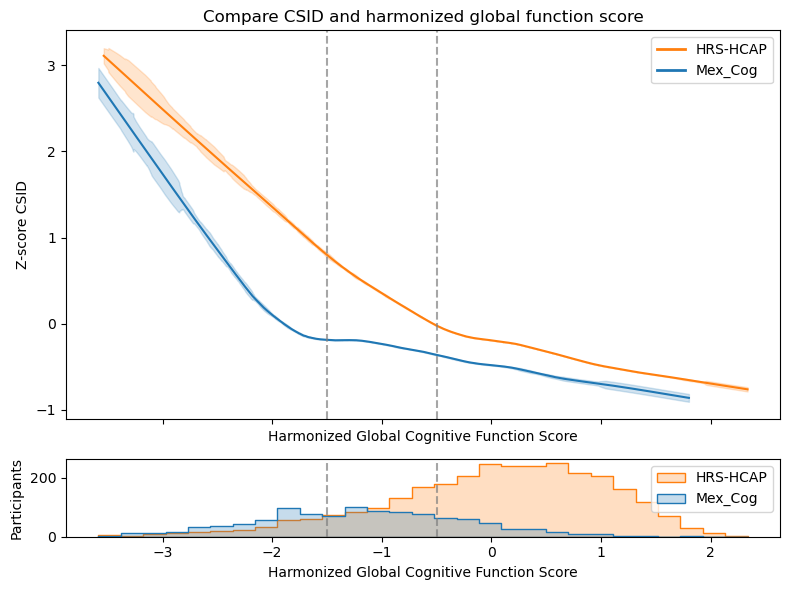

In [108]:
# Get the default seaborn color palette that is used in the histogram
palette = sns.color_palette('tab10', 2)  # Extract 2 colors from Seaborn's 'colorblind' palette

# Use the same palette colors for HRS-HCAP and Mex_Cog
colors = {'HRS-HCAP': palette[1], 'Mex_Cog': palette[0]} 

# HRS = 1 (Group 1)
filtered_data_hrs1 = data[data['hrs'] == 1]
lowess_hrs1 = lowess(endog=filtered_data_hrs1['zbcsid'], exog=filtered_data_hrs1['fgcp'], frac=0.35)
x_hrs1, y_hrs1, y_std_hrs1 = rolling_std(lowess_hrs1[:, 0], lowess_hrs1[:, 1])

# HRS = 0 (Group 2)
filtered_data_hrs0 = data[data['hrs'] == 0]
lowess_hrs0 = lowess(endog=filtered_data_hrs0['zbcsid'], exog=filtered_data_hrs0['fgcp'], frac=0.35)
x_hrs0, y_hrs0, y_std_hrs0 = rolling_std(lowess_hrs0[:, 0], lowess_hrs0[:, 1])

# Create a figure with two subplots, sharing the same x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [5, 1]}, figsize=(8, 6))

# Line plot on the top subplot (ax1)
ax1.plot(lowess_hrs1[:, 0], lowess_hrs1[:, 1], label=f'{var} (hrs = 1)', color=colors['HRS-HCAP'])
ax1.fill_between(x_hrs1, y_hrs1 - y_std_hrs1, y_hrs1 + y_std_hrs1, color=colors['HRS-HCAP'], alpha=0.2)
ax1.plot(lowess_hrs0[:, 0], lowess_hrs0[:, 1], label=f'{var} (hrs = 0)', color=colors['Mex_Cog'])
ax1.fill_between(x_hrs0, y_hrs0 - y_std_hrs0, y_hrs0 + y_std_hrs0, color=colors['Mex_Cog'], alpha=0.2)
ax1.set_ylabel('Z-score CSID')  
ax1.set_title('Compare CSID and harmonized global function score')
ax1.set_xlabel('Harmonized Global Cognitive Function Score')
ax1.axvline(x=-1.5, color='grey', linestyle='--', alpha=0.7)
ax1.axvline(x=-0.5, color='grey', linestyle='--', alpha=0.7)
legend_lines = [Line2D([0], [0], color=colors['HRS-HCAP'], lw=2, label='HRS-HCAP'),
                Line2D([0], [0], color=colors['Mex_Cog'], lw=2, label='Mex_Cog')]
# Add the custom legend
ax1.legend(handles=legend_lines)


# Histogram on the bottom subplot (ax2)
sns.histplot(data=data, x='fgcp', hue='hrs', element="step", ax=ax2)
ax2.set_ylabel('Participants') 
ax2.set_xlabel('Harmonized Global Cognitive Function Score')
ax2.legend(labels=['HRS-HCAP', 'Mex_Cog'])
ax2.axvline(x=-1.5, color='grey', linestyle='--', alpha=0.7)
ax2.axvline(x=-0.5, color='grey', linestyle='--', alpha=0.7)

# Adjust the layout to make it look nice
plt.tight_layout()

# Show the plot
plt.show()


In [18]:
# Create dummy variables for 'relation' with the desired naming
relation_dummies = pd.get_dummies(data['relation'], drop_first=True)

# Rename the columns to "relation_rX" format (e.g., relation_r2, relation_r3)
relation_dummies.columns = ['relation_r' + str(int(col)) for col in relation_dummies.columns]

# Combine the dummy variables with the main dataframe
data = pd.concat([data, relation_dummies], axis=1)

# Create interaction terms between the dummy variables and 'hrs'
for col in relation_dummies.columns:
    data[col + 'HRS'] = data[col] * data['hrs']

In [19]:
# Comprehensive regression model with interaction terms
model_comprehensive = smf.ols('bcsid ~ rage + rfemale + reduc + iage + ifemale + ieduc + coresi + C(relation) + fgcp + '
                              'rageHRS + rfemaleHRS + reducHRS + iageHRS + ifemaleHRS + ieducHRS + '
                              'coresiHRS + relation_r2HRS + relation_r3HRS + relation_r4HRS + fgcpHRS + hrs',
                              data=data).fit()
print("Comprehensive Regression with Interaction Terms:")
print(model_comprehensive.summary())


Comprehensive Regression with Interaction Terms:
                            OLS Regression Results                            
Dep. Variable:                  bcsid   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     67.56
Date:                Tue, 10 Sep 2024   Prob (F-statistic):          9.25e-254
Time:                        10:12:06   Log-Likelihood:                -9996.6
No. Observations:                3960   AIC:                         2.004e+04
Df Residuals:                    3937   BIC:                         2.018e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [20]:
# Simpler regression model including hrs
model_simple = smf.ols('bcsid ~ rage + rfemale + reduc + iage + ifemale + ieduc + coresi + C(relation) + fgcp + hrs', 
                       data=data).fit()
print("Simpler Regression Including hrs:")
print(model_simple.summary())


Simpler Regression Including hrs:
                            OLS Regression Results                            
Dep. Variable:                  bcsid   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     117.6
Date:                Tue, 10 Sep 2024   Prob (F-statistic):          3.05e-251
Time:                        10:12:06   Log-Likelihood:                -10025.
No. Observations:                3960   AIC:                         2.008e+04
Df Residuals:                    3947   BIC:                         2.016e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
In